In [ ]:
# Enable this cell if using Google Collab:

#!pip install box2d-py
#!pip install gym[Box_2D]

# RESTART RUNTIME AFTER INSTALLING ON GOOGLE COLLAB

### **LunarLander-v2 Discrete (maximum 1000 steps)**
#### Double Deep-Q Neural Network (online model + target Network) similar to the Cart-Pole solution)

#### The input to the network consists of 8 float values that specify the coordinates of the agent, the speed in each direction, the angle...
#### The outputs of the network don't go through any activation function; instead of probabilities, the outputs are directly state-action values (do nothing, fire main engine, fire left engine and fire right engine)
##### (The optimal policy involves choosing the Argmax of the output vector of the Neural Network as the action for the next step).
##### **This environment is considered to be solved when getting an average of 200 over 100 consecutive episodes.**

In [1]:
# Imports the libraries and creates the model:


import random
import numpy as np
from tensorflow import keras
import gym
env = gym.make('LunarLander-v2')
model = keras.Sequential()
model.add (keras.layers.Dense(units = 128, input_shape=(8,), activation = "relu"))
model.add (keras.layers.Dense(units = 128, activation = "relu"))
model.add (keras.layers.Dense(units = 32, activation = "relu"))
model.add (keras.layers.Dense(units = 4))
model.compile(optimizer=keras.optimizers.Adam(lr=0.001),loss ="mse")
#print (model.summary())

# At first, the two models have the same parameters; however, the static model (target network) will be updated less frequently

staticModel = keras.models.clone_model( model, input_tensors=None, clone_function=None)
#print (staticModel.summary())

In [2]:
# Memory Replay is carried out in this function.
# 512 random previous experiences are "remembered" and processed in each step with a batch size of 128
# This way we can prevent overfitting most recent states
# This function has been vectorised with numpy "Put_along_axis" and "Take_along_axis" functions (see comment down below) to avoid a slow "For loop".

def executeMemoryReplayStep(memoryPreviousStates, memoryStates, memoryARD, model, staticModel, itemsInMemory):
    randomList = np.random.permutation(itemsInMemory) # After that number everything is 0
    
    memoryPreviousStates = memoryPreviousStates[randomList[:numberOfLearningFromReplaySteps]]
    memoryStates = memoryStates[randomList[:numberOfLearningFromReplaySteps]]
    memoryARD = memoryARD[randomList[:numberOfLearningFromReplaySteps]]

    
    
    previousState = memoryPreviousStates
    
    state = memoryStates
    
    
    action, reward, done = np.split(memoryARD,3,axis=1)
    
    action = action.astype(int)
    
    target = model.predict(previousState)
    
    # Np.put_along_axis changes the value for the action selected in "action" into the "target" array.
    # I.e., for each row, one of the four columns are modified, these indexes (0,1,2,3) for each row appear in the "action" array
    # The individual updates are those of the Q-learning algorithm: only the reward obtained if done=False=0 and the reward plus the discounted value of the next state if done=True=1
    # However, given than now we have two networks, the online network will still use Argmax to choose the action to do in each future state but the value of such action is given by the staticModel instead.
    # This way, with Np.Take_long_axis, we take from the staticModelPredictions those indexes that correspond to the argmax of the predictions of the onlineModel for each future state. I.e, online model chooses an action and we take that index from the predictions of the static model for each future state:
    np.put_along_axis(target, action, (reward + (1-done)*discount*np.take_along_axis(staticModel.predict(state),np.expand_dims(np.argmax(model.predict(state), axis=1),axis=1),axis=1)), axis=1)
    
    
    targetArray = np.array(target)
    
    model.fit(memoryPreviousStates, targetArray, epochs=1, verbose = 0, batch_size =128)


In [3]:
# Function used to soft update the static Model weights for any given Tau:

def updateStaticWeights(model, staticModel,tau):
    modelWeights = model.get_weights()
    staticWeights = staticModel.get_weights()
    
    #Python broadcasting:
    
    for i in range (len(staticWeights)):
     
        staticWeights[i] = (1-tau) * staticWeights[i] + tau * modelWeights[i]

        
    staticModel.set_weights(staticWeights)


    return model, staticModel

In [4]:
numberEpisodes = 500

discount = 0.99
counter = 0
epsilon = 1
epsilonDecay = 0.995
rewards = []
tau = 0.5
memorySize = 50000
memoryPreviousStates = np.zeros((memorySize,8))
memoryStates = np.zeros((memorySize,8))
memoryARD = np.zeros((memorySize,3))
numberOfLearningFromReplaySteps = 512
itemsInMemory = 0
initialiseReplayAfter = 1000 

for episode in range (numberEpisodes):
    epsilon = max (epsilon*epsilonDecay, 0.1)
    
    
    done = False
    prevObs = env.reset()
    
    episodeReward = 0
    for step in range (2000):
        if done:
            break
        #env.render()
        

        target = model.predict(np.expand_dims(prevObs, axis = 0))[0]
        if (random.random()<epsilon):
            action = random.choice([0,1,2,3 ])
        else:
            action = np.argmax(target)
        
        obs, reward, done, _ = env.step (action)


        memoryPreviousStates[counter] = prevObs
        memoryStates[counter] = obs
        
        memoryARD[counter] = [float(action), reward, float (done)]
        
        if (counter % 3000 == 0):
            model.save_weights("lunarweights.h5")
            model, staticModel = updateStaticWeights(model, staticModel,tau)
            print ("STATIC WEIGHTS UPDATED")
        
        if (itemsInMemory < (counter+1)):
            itemsInMemory = min ((itemsInMemory+1), memorySize)
        if (itemsInMemory >= initialiseReplayAfter):
            executeMemoryReplayStep(memoryPreviousStates, memoryStates, memoryARD, model, staticModel, itemsInMemory)


        prevObs = obs
        episodeReward += reward
        counter = (counter + 1) % memorySize
    print (episode, " Episode Reward: ", episodeReward, ".Epsilon:", epsilon)
    rewards.append(episodeReward)

env.close()
model.save_weights("lunarweights.h5")

STATIC WEIGHTS UPDATED
0  Episode Reward:  -93.23026549102762 .Epsilon: 0.995
1  Episode Reward:  -220.95275001998573 .Epsilon: 0.990025
2  Episode Reward:  -290.7317136294014 .Epsilon: 0.985074875
3  Episode Reward:  -296.5621649661626 .Epsilon: 0.9801495006250001
4  Episode Reward:  -90.11528835417138 .Epsilon: 0.9752487531218751
5  Episode Reward:  -175.6114183186067 .Epsilon: 0.9703725093562657
6  Episode Reward:  -91.59718120957886 .Epsilon: 0.9655206468094844
7  Episode Reward:  -162.25641585896642 .Epsilon: 0.960693043575437
8  Episode Reward:  -178.88101159202404 .Epsilon: 0.9558895783575597
9  Episode Reward:  -131.37768900019714 .Epsilon: 0.9511101304657719
10  Episode Reward:  -109.01443080941493 .Epsilon: 0.946354579813443
11  Episode Reward:  -193.06551739377267 .Epsilon: 0.9416228069143757
12  Episode Reward:  -95.21105432967117 .Epsilon: 0.9369146928798039
13  Episode Reward:  -232.37175769528824 .Epsilon: 0.9322301194154049
14  Episode Reward:  -116.3234250446013 .Epsil

117  Episode Reward:  -124.91671871787877 .Epsilon: 0.5535075230322891
118  Episode Reward:  -98.23904033520674 .Epsilon: 0.5507399854171277
119  Episode Reward:  -414.462846317011 .Epsilon: 0.547986285490042
120  Episode Reward:  -70.07441226212117 .Epsilon: 0.5452463540625918
121  Episode Reward:  -143.10535228010838 .Epsilon: 0.5425201222922789
122  Episode Reward:  -91.8157840495884 .Epsilon: 0.5398075216808175
123  Episode Reward:  -124.27697167678865 .Epsilon: 0.5371084840724134
STATIC WEIGHTS UPDATED
124  Episode Reward:  -25.15821207875767 .Epsilon: 0.5344229416520513
125  Episode Reward:  -123.4844318950074 .Epsilon: 0.531750826943791
126  Episode Reward:  -123.85877780694685 .Epsilon: 0.5290920728090721
127  Episode Reward:  -56.65319432274562 .Epsilon: 0.5264466124450268
128  Episode Reward:  -33.40814140955139 .Epsilon: 0.5238143793828016
129  Episode Reward:  -231.32523164901795 .Epsilon: 0.5211953074858876
130  Episode Reward:  -115.40681782313288 .Epsilon: 0.518589330948

231  Episode Reward:  -87.55229007488445 .Epsilon: 0.3125753549412418
232  Episode Reward:  -684.2388412488127 .Epsilon: 0.31101247816653554
233  Episode Reward:  -21.125123005346254 .Epsilon: 0.30945741577570285
STATIC WEIGHTS UPDATED
234  Episode Reward:  -121.39181491995275 .Epsilon: 0.3079101286968243
235  Episode Reward:  -107.4637880730007 .Epsilon: 0.3063705780533402
236  Episode Reward:  -25.44626342815367 .Epsilon: 0.30483872516307353
237  Episode Reward:  -287.901551419147 .Epsilon: 0.3033145315372582
238  Episode Reward:  -235.7254548033447 .Epsilon: 0.3017979588795719
STATIC WEIGHTS UPDATED
239  Episode Reward:  -334.85098696581395 .Epsilon: 0.30028896908517405
240  Episode Reward:  39.385803224419845 .Epsilon: 0.2987875242397482
241  Episode Reward:  22.17982554448581 .Epsilon: 0.29729358661854943
242  Episode Reward:  1.3216412503364552 .Epsilon: 0.29580711868545667
243  Episode Reward:  -8.893167216723313 .Epsilon: 0.2943280830920294
244  Episode Reward:  -100.5192176475

STATIC WEIGHTS UPDATED
339  Episode Reward:  81.83414791800341 .Epsilon: 0.18190617987607657
340  Episode Reward:  -147.7141388071107 .Epsilon: 0.18099664897669618
341  Episode Reward:  -17.808617577196767 .Epsilon: 0.1800916657318127
342  Episode Reward:  -56.066348700821074 .Epsilon: 0.17919120740315364
343  Episode Reward:  -40.004817482668415 .Epsilon: 0.17829525136613786
344  Episode Reward:  -84.7856152838055 .Epsilon: 0.17740377510930716
STATIC WEIGHTS UPDATED
345  Episode Reward:  -42.93071203073396 .Epsilon: 0.17651675623376062
346  Episode Reward:  -97.5247899324323 .Epsilon: 0.1756341724525918
347  Episode Reward:  -84.92879850130441 .Epsilon: 0.17475600159032884
348  Episode Reward:  47.56536615625295 .Epsilon: 0.17388222158237718
STATIC WEIGHTS UPDATED
349  Episode Reward:  -70.10547410474373 .Epsilon: 0.1730128104744653
350  Episode Reward:  38.32928530317553 .Epsilon: 0.17214774642209296
351  Episode Reward:  52.456693148947785 .Epsilon: 0.1712870076899825
352  Episode R

448  Episode Reward:  -19.697623271889952 .Epsilon: 0.10533270926593409
449  Episode Reward:  -5.140435499063258 .Epsilon: 0.10480604571960442
450  Episode Reward:  24.395129144278314 .Epsilon: 0.1042820154910064
451  Episode Reward:  164.63317212183668 .Epsilon: 0.10376060541355137
STATIC WEIGHTS UPDATED
452  Episode Reward:  243.56377216765378 .Epsilon: 0.1032418023864836
453  Episode Reward:  141.02323121829983 .Epsilon: 0.10272559337455119
454  Episode Reward:  107.46755434732277 .Epsilon: 0.10221196540767843
455  Episode Reward:  -44.668661739359834 .Epsilon: 0.10170090558064004
456  Episode Reward:  229.7828340834984 .Epsilon: 0.10119240105273684
STATIC WEIGHTS UPDATED
457  Episode Reward:  -219.99003509359727 .Epsilon: 0.10068643904747315
458  Episode Reward:  -66.51808033556844 .Epsilon: 0.10018300685223579
459  Episode Reward:  -455.76633842750596 .Epsilon: 0.1
460  Episode Reward:  -25.733496907670794 .Epsilon: 0.1
461  Episode Reward:  -111.2953390503812 .Epsilon: 0.1
462  E

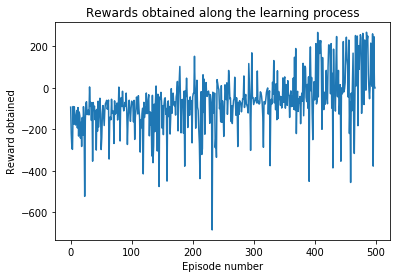

In [6]:
import matplotlib.pyplot as plt
plt.plot (list(range(len(rewards))), rewards)
plt.title("Rewards obtained along the learning process")
plt.xlabel("Episode number")
plt.ylabel("Reward obtained")
plt.show()

### Let's train the agent for longer:

In [8]:
for episode in range ((numberEpisodes),(numberEpisodes+1500)):
    epsilon = max (epsilon*epsilonDecay, 0.1)
    
    
    done = False
    prevObs = env.reset()
    
    episodeReward = 0
    for step in range (2000):
        if done:
            break
        #env.render()
        

        target = model.predict(np.expand_dims(prevObs, axis = 0))[0]
        if (random.random()<epsilon):
            action = random.choice([0,1,2,3 ])
        else:
            action = np.argmax(target)
        
        obs, reward, done, _ = env.step (action)


        memoryPreviousStates[counter] = prevObs
        memoryStates[counter] = obs
        
        memoryARD[counter] = [float(action), reward, float (done)]
        
        if (counter % 3000 == 0):
            model.save_weights("lunarweights.h5")
            model, staticModel = updateStaticWeights(model, staticModel,tau)
            print ("STATIC WEIGHTS UPDATED")
        
        if (itemsInMemory < (counter+1)):
            itemsInMemory = min ((itemsInMemory+1), memorySize)
        if (itemsInMemory >= initialiseReplayAfter):
            executeMemoryReplayStep(memoryPreviousStates, memoryStates, memoryARD, model, staticModel, itemsInMemory)


        prevObs = obs
        episodeReward += reward
        counter = (counter + 1) % memorySize
    print (episode, " Episode Reward: ", episodeReward, ".Epsilon:", epsilon)
    rewards.append(episodeReward)

env.close()
model.save_weights("lunarweights.h5")

500  Episode Reward:  -109.79763766142601 .Epsilon: 0.1
501  Episode Reward:  -0.6926218970971547 .Epsilon: 0.1
502  Episode Reward:  239.9192870660363 .Epsilon: 0.1
503  Episode Reward:  -22.132765801565355 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
504  Episode Reward:  -8.446257067771166 .Epsilon: 0.1
505  Episode Reward:  -88.91849606880584 .Epsilon: 0.1
506  Episode Reward:  20.67406663073764 .Epsilon: 0.1
507  Episode Reward:  -42.84748583129691 .Epsilon: 0.1
508  Episode Reward:  259.9588067143078 .Epsilon: 0.1
509  Episode Reward:  234.42994361026857 .Epsilon: 0.1
510  Episode Reward:  238.40671380337676 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
511  Episode Reward:  245.3760716081011 .Epsilon: 0.1
512  Episode Reward:  261.0793620544932 .Epsilon: 0.1
513  Episode Reward:  229.80589505140375 .Epsilon: 0.1
514  Episode Reward:  -41.89311042831295 .Epsilon: 0.1
515  Episode Reward:  241.81033674671897 .Epsilon: 0.1
516  Episode Reward:  6.835509889603273 .Epsilon: 0.1
517  Episode Reward:  

643  Episode Reward:  236.96234625383906 .Epsilon: 0.1
644  Episode Reward:  -249.44614700032085 .Epsilon: 0.1
645  Episode Reward:  290.835647312998 .Epsilon: 0.1
646  Episode Reward:  -18.41894367170093 .Epsilon: 0.1
647  Episode Reward:  244.4553670409381 .Epsilon: 0.1
648  Episode Reward:  -42.97626322194949 .Epsilon: 0.1
649  Episode Reward:  -255.1316086101092 .Epsilon: 0.1
650  Episode Reward:  49.31742744704417 .Epsilon: 0.1
651  Episode Reward:  167.23524328003765 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
652  Episode Reward:  271.17711681326625 .Epsilon: 0.1
653  Episode Reward:  9.439882865372923 .Epsilon: 0.1
654  Episode Reward:  264.30633626351266 .Epsilon: 0.1
655  Episode Reward:  68.52630632537995 .Epsilon: 0.1
656  Episode Reward:  237.25402461649907 .Epsilon: 0.1
657  Episode Reward:  -2.190529396760013 .Epsilon: 0.1
658  Episode Reward:  -203.49290176040842 .Epsilon: 0.1
659  Episode Reward:  167.46218122712588 .Epsilon: 0.1
660  Episode Reward:  242.90398539820134 .Epsi

787  Episode Reward:  12.719086154837242 .Epsilon: 0.1
788  Episode Reward:  253.80128484308727 .Epsilon: 0.1
789  Episode Reward:  -296.3932309008379 .Epsilon: 0.1
790  Episode Reward:  228.23174256594078 .Epsilon: 0.1
791  Episode Reward:  -130.20680242275836 .Epsilon: 0.1
792  Episode Reward:  219.1216879429834 .Epsilon: 0.1
793  Episode Reward:  -215.21923733100598 .Epsilon: 0.1
794  Episode Reward:  27.383850467545685 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
795  Episode Reward:  -205.74836730827525 .Epsilon: 0.1
796  Episode Reward:  12.731831859617571 .Epsilon: 0.1
797  Episode Reward:  -153.01318382486429 .Epsilon: 0.1
798  Episode Reward:  242.04791052395558 .Epsilon: 0.1
799  Episode Reward:  -31.64403942249031 .Epsilon: 0.1
800  Episode Reward:  27.21847916298293 .Epsilon: 0.1
801  Episode Reward:  -53.1434824075137 .Epsilon: 0.1
802  Episode Reward:  -244.25390921173675 .Epsilon: 0.1
803  Episode Reward:  266.90587049300996 .Epsilon: 0.1
804  Episode Reward:  35.70484927025237 

932  Episode Reward:  -78.0522589810595 .Epsilon: 0.1
933  Episode Reward:  -62.40382418922319 .Epsilon: 0.1
934  Episode Reward:  -360.3539071635833 .Epsilon: 0.1
935  Episode Reward:  -82.6662608763703 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
936  Episode Reward:  257.90378535894854 .Epsilon: 0.1
937  Episode Reward:  -190.43923344021175 .Epsilon: 0.1
938  Episode Reward:  -348.1569466927139 .Epsilon: 0.1
939  Episode Reward:  -69.20397321974072 .Epsilon: 0.1
940  Episode Reward:  251.1795572207647 .Epsilon: 0.1
941  Episode Reward:  -256.7747341712492 .Epsilon: 0.1
942  Episode Reward:  -307.5861703963366 .Epsilon: 0.1
943  Episode Reward:  -263.8472651598323 .Epsilon: 0.1
944  Episode Reward:  274.5058725446514 .Epsilon: 0.1
945  Episode Reward:  -222.4315884742147 .Epsilon: 0.1
946  Episode Reward:  -305.98255843014283 .Epsilon: 0.1
947  Episode Reward:  -95.09249117794384 .Epsilon: 0.1
948  Episode Reward:  40.7106213834021 .Epsilon: 0.1
949  Episode Reward:  -17.95540989566834 .Epsi

1075  Episode Reward:  -62.33757905064579 .Epsilon: 0.1
1076  Episode Reward:  253.1767095752744 .Epsilon: 0.1
1077  Episode Reward:  58.09910326706955 .Epsilon: 0.1
1078  Episode Reward:  227.2367862705065 .Epsilon: 0.1
1079  Episode Reward:  -45.14607102341243 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
1080  Episode Reward:  -256.81967095624157 .Epsilon: 0.1
1081  Episode Reward:  -90.82293776761902 .Epsilon: 0.1
1082  Episode Reward:  -243.03396694612894 .Epsilon: 0.1
1083  Episode Reward:  -240.6799440263334 .Epsilon: 0.1
1084  Episode Reward:  172.6137769800315 .Epsilon: 0.1
1085  Episode Reward:  267.90298300687493 .Epsilon: 0.1
1086  Episode Reward:  293.9966568289727 .Epsilon: 0.1
1087  Episode Reward:  227.80059103720686 .Epsilon: 0.1
1088  Episode Reward:  -10.712393649653933 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
1089  Episode Reward:  295.1382530169625 .Epsilon: 0.1
1090  Episode Reward:  18.231463169078353 .Epsilon: 0.1
1091  Episode Reward:  -293.24349412548577 .Epsilon: 0.1
1092

1217  Episode Reward:  -250.00995201904223 .Epsilon: 0.1
1218  Episode Reward:  7.310235573595477 .Epsilon: 0.1
1219  Episode Reward:  -103.14041554616851 .Epsilon: 0.1
1220  Episode Reward:  -122.42633348795657 .Epsilon: 0.1
1221  Episode Reward:  -149.03682948264463 .Epsilon: 0.1
1222  Episode Reward:  281.2101510116486 .Epsilon: 0.1
1223  Episode Reward:  -93.07327607207732 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
1224  Episode Reward:  -181.68665250062267 .Epsilon: 0.1
1225  Episode Reward:  -35.41850704374299 .Epsilon: 0.1
1226  Episode Reward:  264.43266049238946 .Epsilon: 0.1
1227  Episode Reward:  -170.3441694914498 .Epsilon: 0.1
1228  Episode Reward:  257.60024425545146 .Epsilon: 0.1
1229  Episode Reward:  254.76633742521287 .Epsilon: 0.1
1230  Episode Reward:  261.98121177879796 .Epsilon: 0.1
1231  Episode Reward:  -147.7827997673837 .Epsilon: 0.1
1232  Episode Reward:  269.05900011415224 .Epsilon: 0.1
1233  Episode Reward:  -25.843462920323645 .Epsilon: 0.1
1234  Episode Reward:

STATIC WEIGHTS UPDATED
1359  Episode Reward:  261.6335479680688 .Epsilon: 0.1
1360  Episode Reward:  162.4303230788051 .Epsilon: 0.1
1361  Episode Reward:  262.1143540461059 .Epsilon: 0.1
1362  Episode Reward:  -178.46751348337938 .Epsilon: 0.1
1363  Episode Reward:  -171.47444913846996 .Epsilon: 0.1
1364  Episode Reward:  25.734183011935315 .Epsilon: 0.1
1365  Episode Reward:  -145.86315723310338 .Epsilon: 0.1
1366  Episode Reward:  45.012479374781435 .Epsilon: 0.1
1367  Episode Reward:  -261.0726554374324 .Epsilon: 0.1
1368  Episode Reward:  14.854392619737993 .Epsilon: 0.1
1369  Episode Reward:  36.26708146789639 .Epsilon: 0.1
1370  Episode Reward:  0.5350832995605828 .Epsilon: 0.1
1371  Episode Reward:  -86.09597546923301 .Epsilon: 0.1
1372  Episode Reward:  213.59593478572444 .Epsilon: 0.1
1373  Episode Reward:  -159.58572777298414 .Epsilon: 0.1
1374  Episode Reward:  -321.19288086878163 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
1375  Episode Reward:  275.4938440377133 .Epsilon: 0.1
13

1500  Episode Reward:  246.68332935902356 .Epsilon: 0.1
1501  Episode Reward:  -5.128544665069725 .Epsilon: 0.1
1502  Episode Reward:  239.03990635196763 .Epsilon: 0.1
1503  Episode Reward:  244.1682520177093 .Epsilon: 0.1
1504  Episode Reward:  285.04078645415984 .Epsilon: 0.1
1505  Episode Reward:  236.16543015729755 .Epsilon: 0.1
1506  Episode Reward:  295.2045501042083 .Epsilon: 0.1
1507  Episode Reward:  260.07084101257664 .Epsilon: 0.1
1508  Episode Reward:  272.45475964983973 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
1509  Episode Reward:  -114.85208159100773 .Epsilon: 0.1
1510  Episode Reward:  261.5100392966534 .Epsilon: 0.1
1511  Episode Reward:  249.6545064071451 .Epsilon: 0.1
1512  Episode Reward:  -4.423008791166069 .Epsilon: 0.1
1513  Episode Reward:  231.51354203814157 .Epsilon: 0.1
1514  Episode Reward:  5.375056345090741 .Epsilon: 0.1
1515  Episode Reward:  280.7388899635371 .Epsilon: 0.1
1516  Episode Reward:  267.1482817897795 .Epsilon: 0.1
1517  Episode Reward:  251.7535

STATIC WEIGHTS UPDATED
1641  Episode Reward:  -293.0472088835095 .Epsilon: 0.1
1642  Episode Reward:  254.7459117079398 .Epsilon: 0.1
1643  Episode Reward:  273.0392072725314 .Epsilon: 0.1
1644  Episode Reward:  258.5336706700429 .Epsilon: 0.1
1645  Episode Reward:  12.275974146040838 .Epsilon: 0.1
1646  Episode Reward:  282.66693595275564 .Epsilon: 0.1
1647  Episode Reward:  237.60520021056234 .Epsilon: 0.1
1648  Episode Reward:  19.291147521921786 .Epsilon: 0.1
1649  Episode Reward:  -33.9907129188299 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
1650  Episode Reward:  -237.6886867117075 .Epsilon: 0.1
1651  Episode Reward:  285.15847467663286 .Epsilon: 0.1
1652  Episode Reward:  270.62546813551427 .Epsilon: 0.1
1653  Episode Reward:  253.33160112293953 .Epsilon: 0.1
1654  Episode Reward:  256.3659307732576 .Epsilon: 0.1
1655  Episode Reward:  293.4692158189305 .Epsilon: 0.1
1656  Episode Reward:  291.1156096500001 .Epsilon: 0.1
1657  Episode Reward:  251.88825479648747 .Epsilon: 0.1
1658  Epi

1782  Episode Reward:  -150.3914409558448 .Epsilon: 0.1
1783  Episode Reward:  269.5669404843359 .Epsilon: 0.1
1784  Episode Reward:  258.91419732052435 .Epsilon: 0.1
1785  Episode Reward:  283.05263275815275 .Epsilon: 0.1
1786  Episode Reward:  239.97651079423437 .Epsilon: 0.1
1787  Episode Reward:  13.843699838752173 .Epsilon: 0.1
1788  Episode Reward:  278.95061619552905 .Epsilon: 0.1
1789  Episode Reward:  253.60334818858917 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
1790  Episode Reward:  224.97940144122316 .Epsilon: 0.1
1791  Episode Reward:  269.57976020944363 .Epsilon: 0.1
1792  Episode Reward:  283.8282621008457 .Epsilon: 0.1
1793  Episode Reward:  233.02254665925173 .Epsilon: 0.1
1794  Episode Reward:  123.02720250800772 .Epsilon: 0.1
1795  Episode Reward:  41.29182229740536 .Epsilon: 0.1
1796  Episode Reward:  30.3892129907465 .Epsilon: 0.1
1797  Episode Reward:  -13.050892306931345 .Epsilon: 0.1
1798  Episode Reward:  258.629547326874 .Epsilon: 0.1
1799  Episode Reward:  25.55559

1923  Episode Reward:  208.1010838660922 .Epsilon: 0.1
1924  Episode Reward:  281.5378230634942 .Epsilon: 0.1
1925  Episode Reward:  272.2783647352014 .Epsilon: 0.1
1926  Episode Reward:  23.33759787920272 .Epsilon: 0.1
1927  Episode Reward:  253.79424546068202 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
1928  Episode Reward:  249.64939138651613 .Epsilon: 0.1
1929  Episode Reward:  223.79224972698603 .Epsilon: 0.1
1930  Episode Reward:  -89.40948381583226 .Epsilon: 0.1
1931  Episode Reward:  25.471751833905046 .Epsilon: 0.1
1932  Episode Reward:  122.32425107770065 .Epsilon: 0.1
1933  Episode Reward:  203.21688136279136 .Epsilon: 0.1
1934  Episode Reward:  263.85371249744856 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
1935  Episode Reward:  -99.86065027307967 .Epsilon: 0.1
1936  Episode Reward:  256.41685228297956 .Epsilon: 0.1
1937  Episode Reward:  228.53847501671245 .Epsilon: 0.1
1938  Episode Reward:  265.92523769400304 .Epsilon: 0.1
1939  Episode Reward:  273.73060842822326 .Epsilon: 0.1
1940  

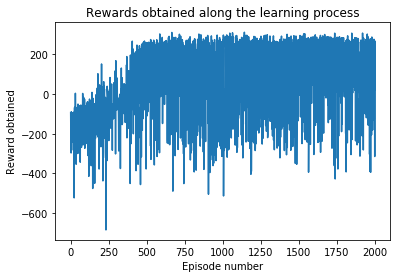

In [9]:
plt.plot (list(range(len(rewards))), rewards)
plt.title("Rewards obtained along the learning process")
plt.xlabel("Episode number")
plt.ylabel("Reward obtained")
plt.show()

## The agent has learnt to land on the moon.
### However, it must be considered that the agent does not have any input of the surface of the moon in each episode. This results in instability given that the mountains and valleys are located in different places each time and the agent cannot know where.

In [10]:
# Testing loop (Google colab cannot render the environment, only computations can be done. Render in Local Machine!)

numberOfTestingEpisodes = 100
testingRewards = []
for episode in range (numberOfTestingEpisodes):
    done = False
    episodeReward = 0
    prevObs = env.reset()
    for step in range (1010):
       
        if done:
            break
        #env.render()
        
       

        target = model.predict(np.expand_dims(prevObs, axis = 0))[0]

        action = np.argmax(target)
        
        
        obs, reward, done, info = env.step (action)
        
        prevObs = obs
        episodeReward += reward
      
    print (episode, " Episode Reward: ", episodeReward)
    testingRewards.append(episodeReward)
env.close()

0  Episode Reward:  -295.46750922065763
1  Episode Reward:  227.57930211424892
2  Episode Reward:  32.83854192278031
3  Episode Reward:  247.00420060176486
4  Episode Reward:  235.91761262820563
5  Episode Reward:  -14.708754489741423
6  Episode Reward:  259.0749561320472
7  Episode Reward:  278.1739206104837
8  Episode Reward:  -125.63615510786114
9  Episode Reward:  27.016783195873273
10  Episode Reward:  255.74274279375055
11  Episode Reward:  231.45247510020738
12  Episode Reward:  -763.6073317123885
13  Episode Reward:  169.08154499111646
14  Episode Reward:  158.70828490362396
15  Episode Reward:  254.94165907190325
16  Episode Reward:  -21.91389325278479
17  Episode Reward:  264.6055424906254
18  Episode Reward:  255.58705418925527
19  Episode Reward:  22.739065478757055
20  Episode Reward:  2.53890935058638
21  Episode Reward:  216.23855535032604
22  Episode Reward:  235.0771972706513
23  Episode Reward:  -6.385638467687841
24  Episode Reward:  18.118904573157806
25  Episode Re

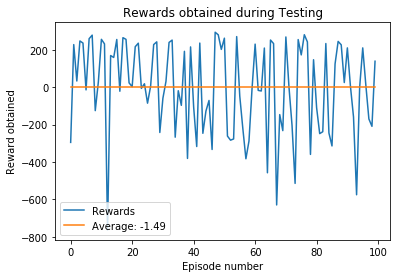

In [11]:
import matplotlib.pyplot as plt
plt.plot (list(range(len(testingRewards))), testingRewards)
plt.plot (list(range(len(testingRewards))), [np.average(testingRewards)]*len(testingRewards))
plt.title("Rewards obtained during Testing")
plt.xlabel("Episode number")
plt.ylabel("Reward obtained")
plt.legend(["Rewards", "Average: %.2f" % np.average(testingRewards)])
plt.show()

### After 2000 episodes the agent's performance has worsen a bit. Its results depend too much on the random surface generation in each iteration (the agent state doesn't contain information about the mountains and valleys in the environment). Furthermore, some experiences in which it would go far to the right or to the left and crash are not in its memory arrays anymore. Consequently, it has forgotten how to come back to the middle point. The version saved after 1500 episodes seems more stable:

In [12]:
# Testing loop (Google colab cannot render the environment, only computations can be done. Render in Local Machine!)

model.load_weights("lunarLanderDiscrete1500episodes.h5")
numberOfTestingEpisodes = 100
testingRewards = []
for episode in range (numberOfTestingEpisodes):
    done = False
    episodeReward = 0
    prevObs = env.reset()
    for step in range (1010):
       
        if done:
            break
        env.render()
        
       

        target = model.predict(np.expand_dims(prevObs, axis = 0))[0]

        action = np.argmax(target)
        
        
        obs, reward, done, info = env.step (action)
        
        prevObs = obs
        episodeReward += reward
      
    print (episode, " Episode Reward: ", episodeReward)
    testingRewards.append(episodeReward)
env.close()

0  Episode Reward:  281.2003966223907
1  Episode Reward:  248.10247530273483
2  Episode Reward:  272.5312633050604
3  Episode Reward:  277.96126219298685
4  Episode Reward:  270.8434278449247
5  Episode Reward:  289.73297753724944
6  Episode Reward:  270.0619749707963
7  Episode Reward:  258.7046757079535
8  Episode Reward:  239.06654695988607
9  Episode Reward:  244.0769958934678
10  Episode Reward:  268.04997307797987
11  Episode Reward:  274.15303626145624
12  Episode Reward:  257.0616837235482
13  Episode Reward:  273.73305790190216
14  Episode Reward:  172.33554000293952
15  Episode Reward:  248.56759034705487
16  Episode Reward:  214.29610403072934
17  Episode Reward:  246.62116356530106
18  Episode Reward:  276.8317939308931
19  Episode Reward:  268.71008536238276
20  Episode Reward:  270.2793117448176
21  Episode Reward:  -207.72658107897192
22  Episode Reward:  228.48569696048753
23  Episode Reward:  275.470135965796
24  Episode Reward:  266.1812901660189
25  Episode Reward:  

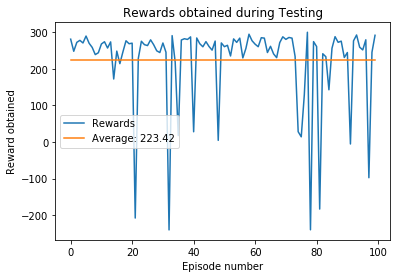

In [13]:
plt.plot (list(range(len(testingRewards))), testingRewards)
plt.plot (list(range(len(testingRewards))), [np.average(testingRewards)]*len(testingRewards))
plt.title("Rewards obtained during Testing")
plt.xlabel("Episode number")
plt.ylabel("Reward obtained")
plt.legend(["Rewards", "Average: %.2f" % np.average(testingRewards)])
plt.show()

### This version manages to solve the environment! 
#### More than 200.0 average over 100 consecutive episodes